apply some clean criteria to reduce backgrounds

one immediate option is distance wrt. AK4CHS (pT>20, HFrac>0.8)

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [38]:
class ak4jetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        multiplicity_axis = hist.Bin('mul', 'multiplicity', 20, 0, 20)
        pt0_axis = hist.Bin('pt', '$p_T$[GeV]', 50, 0, 100)
        pt1_axis = hist.Bin('pt', '$p_T$[GeV]', 50, 0, 1000)
        hadfrac_axis = hist.Bin('hadfrac', 'hadron energy fraction', 50, 0, 1)
        clean_axis = hist.Bin('clean', 'away from hadronic ak4chs', 2, 0, 2)
        self._accumulator = processor.dict_accumulator({
            'mul': hist.Hist('Events', dataset_axis, multiplicity_axis),
            'pt0': hist.Hist('Counts', dataset_axis, pt0_axis),
            'pt1': hist.Hist('Counts', dataset_axis, pt1_axis),
            'hadfrac': hist.Hist('Counts', dataset_axis, hadfrac_axis),
            'clean': hist.Hist('Counts', dataset_axis, clean_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            hadronf=df['akjet_hadronEnergyFraction'],
        )
        ak4chs = ak4chs[(ak4chs.pt>20.) & ((ak4chs.hadronf/ak4chs.p4.energy)>0.6)]
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        match_ = leptonjets.match(ak4chs, deltaRCut=0.4)
        leptonjets.add_attributes(clean=~match_)
#         print(leptonjets.clean)
        output['mul'].fill(dataset=dataset, mul=ak4chs.size)
        output['pt0'].fill(dataset=dataset, pt=ak4chs.pt.flatten())
        output['pt1'].fill(dataset=dataset, pt=ak4chs.pt.flatten())
        output['hadfrac'].fill(dataset=dataset, hadfrac=(ak4chs.hadronf/ak4chs.p4.energy).flatten())
        output['clean'].fill(dataset=dataset, clean=leptonjets.clean.flatten().astype(int))
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [39]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ak4jetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


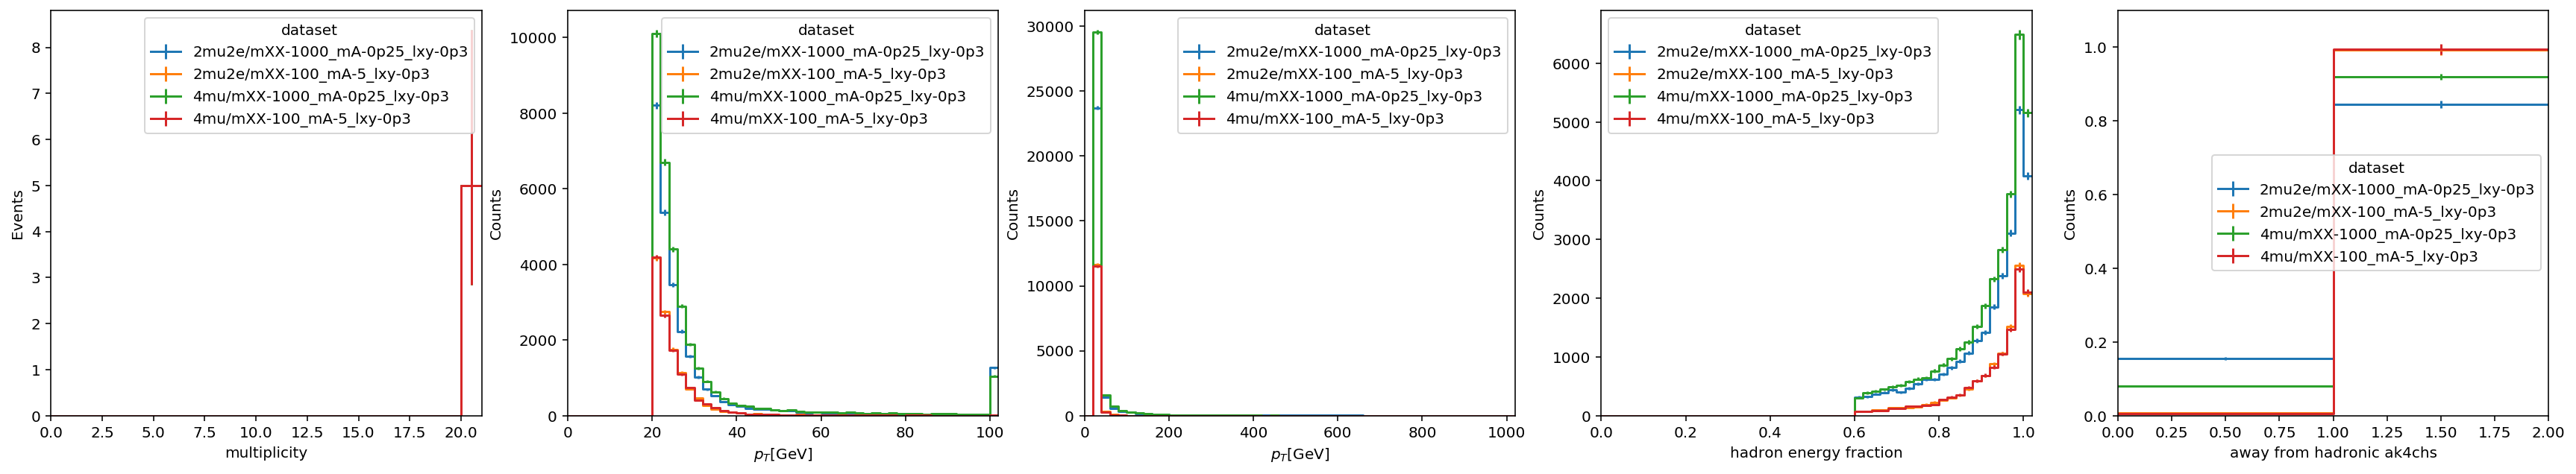

In [40]:
fig, ax = plt.subplots(1,5,figsize=(30,5))
hist.plot1d(output['mul'], overlay='dataset', ax=ax[0], overflow='over')
hist.plot1d(output['pt0'], overlay='dataset', ax=ax[1], overflow='over')
hist.plot1d(output['pt1'], overlay='dataset', ax=ax[2], overflow='over')
hist.plot1d(output['hadfrac'], overlay='dataset', ax=ax[3], overflow='over')
hist.plot1d(output['clean'], overlay='dataset', ax=ax[4], density=True)
ax[4].set_ylim([0, 1.1]);

- lxy: 300cm

In [41]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ak4jetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  3.99items/s]


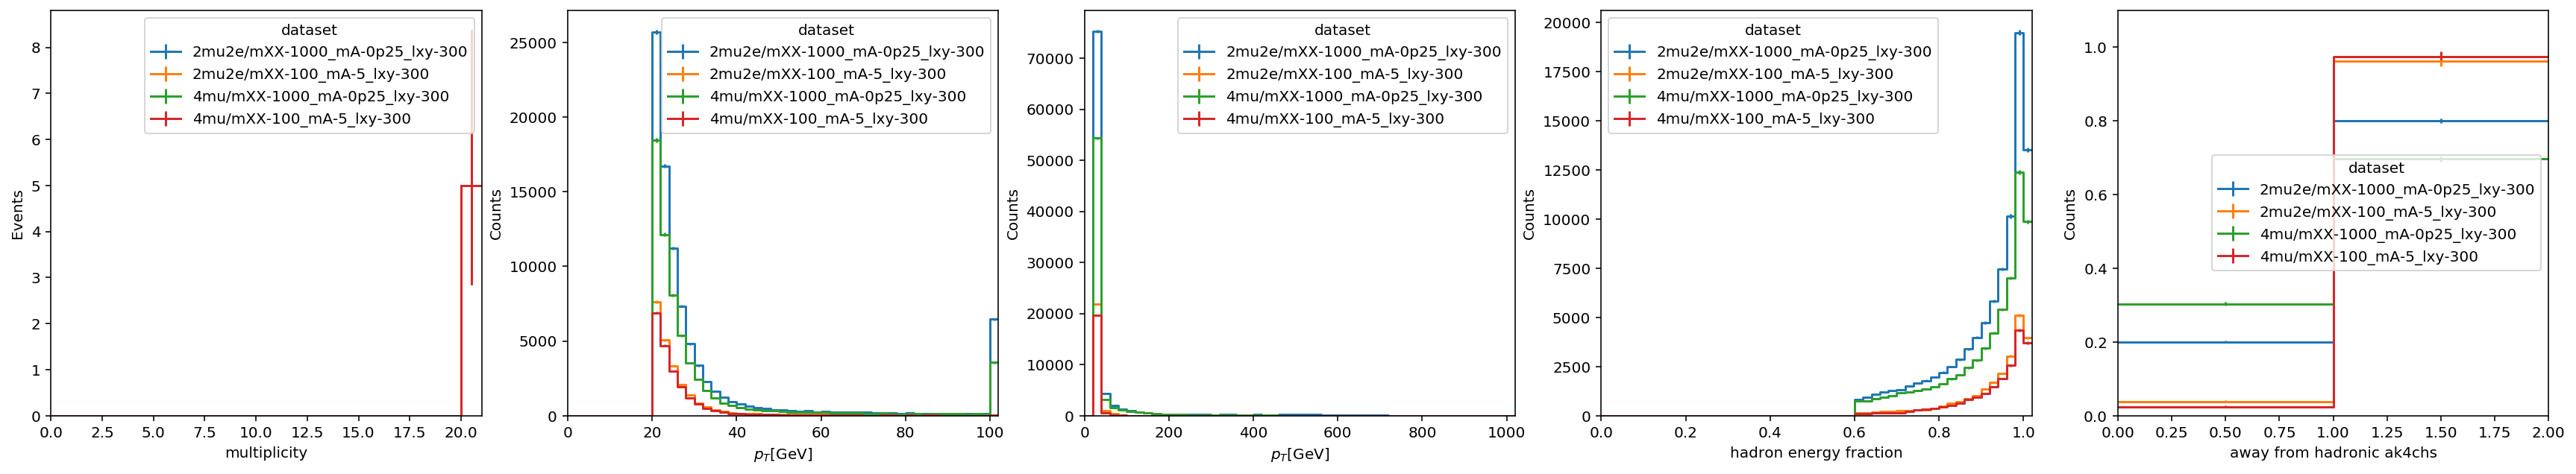

In [42]:
fig, ax = plt.subplots(1,5,figsize=(30,5))
hist.plot1d(output['mul'], overlay='dataset', ax=ax[0], overflow='over')
hist.plot1d(output['pt0'], overlay='dataset', ax=ax[1], overflow='over')
hist.plot1d(output['pt1'], overlay='dataset', ax=ax[2], overflow='over')
hist.plot1d(output['hadfrac'], overlay='dataset', ax=ax[3], overflow='over')
hist.plot1d(output['clean'], overlay='dataset', ax=ax[4], density=True)
ax[4].set_ylim([0,1.1]);

- backgrounds

In [43]:
dataset={
    'DYJets': ['/uscms_data/d3/wsi/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_DYJetsM50.root',],
    'QCD': ['/uscms_data/d3/wsi/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_QCDpT300To470.root',],
    'TTJets': ['/uscms_data/d3/wsi/lpcdm/CMSSW_10_2_14/src/Firefighter/ffConfig/python/test/ffNtuple_TTJets.root',],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ak4jetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 3/3 [00:02<00:00,  1.50items/s]


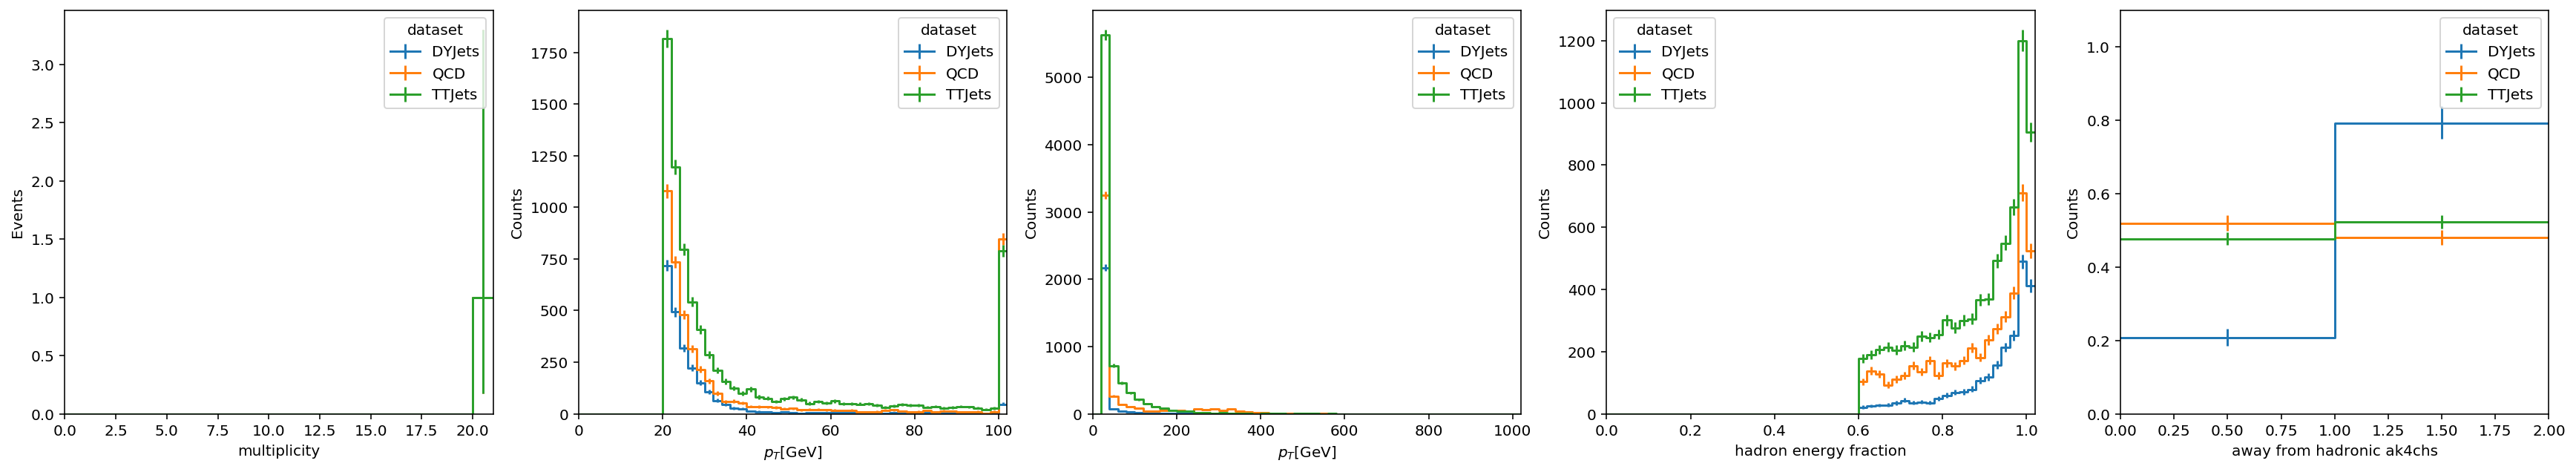

In [44]:
fig, ax = plt.subplots(1,5,figsize=(30,5))
hist.plot1d(output['mul'], overlay='dataset', ax=ax[0], overflow='over')
hist.plot1d(output['pt0'], overlay='dataset', ax=ax[1], overflow='over')
hist.plot1d(output['pt1'], overlay='dataset', ax=ax[2], overflow='over')
hist.plot1d(output['hadfrac'], overlay='dataset', ax=ax[3], overflow='over')
hist.plot1d(output['clean'], overlay='dataset', ax=ax[4], density=True)
ax[4].set_ylim([0,1.1]);